In [ ]:
%matplotlib inline


# Figura 1 Charla: Comparacion de algoritmos


Este ejemplo muestra características de diferentes algoritmos altamente citados en la comunidad de Machine Learning. Los datasets usados son sintéticos y bidimensionales, creados para poder visualizar mejor las particularidades de los algoritmos.
Se ha tratado de mostrar buenos parámetros, para poder mostrar agrupamientos competitivos. 

El último dataset es una nube aleatoria, no debería haber mas de un cluster. Los algortimos automáticos funcionan mejor que los que tienen asignados en forma fija el número de clusters.

Este ejemplo puede ser modificado para presentar sobre estos grupos de datos, salidas de un mismo algoritmo para distintos parámetros. 

La base de esta notebook fue obtenida de sklearn. 


Automatically created module for IPython interactive environment
[-5.19811282e+00 -5.75229538e+00 -1.08448984e+01 ... -9.07491863e-01
 -3.54141108e-01  1.41185693e-03]
[-2.27812175 -2.66683413 -9.19921055 ...  0.22678034  0.17905026
  0.94359219]
[ 0.64186932  0.41862711 -7.55352273 ...  1.36105255  0.71224163
  1.88577252]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

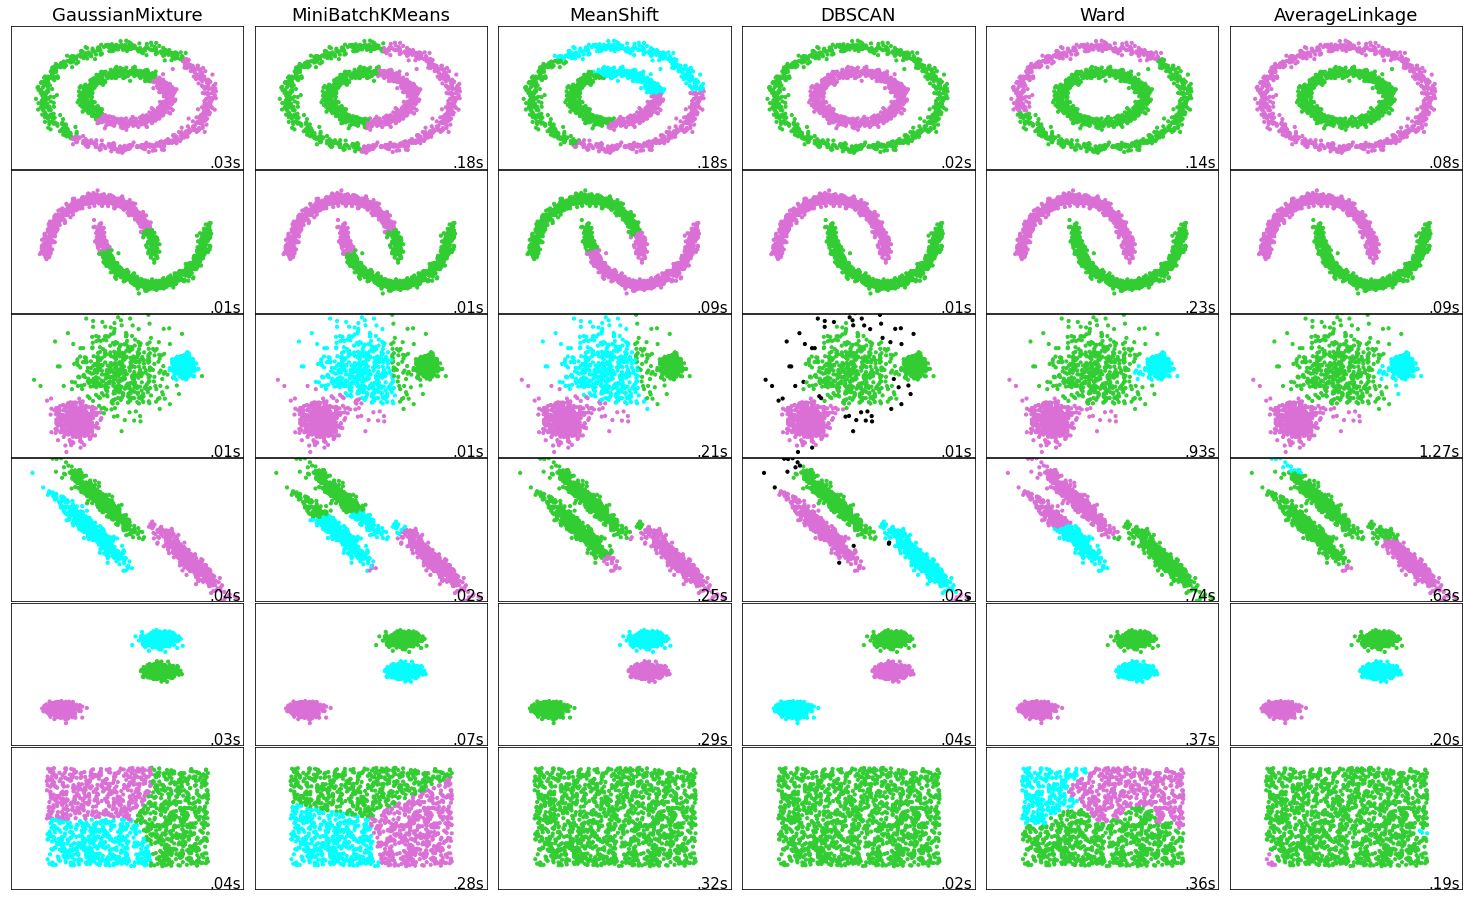

In [1]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generar datasets, Se elige un numero de datos suficientemente grande para tener caracteristicas interesantes 
#sin tener problemas de escala y tiempo de procesamiento
#puede cambiarse
#==========

n_samples = 1500
random_state = 170
#----------
#circulos concentricos con ruido (diana para tirar dardos)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

# dos medias lunas, problematico para agrupamientos por distancia euclidea.
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

# circulos con distintas varianzas por lo cual estan cerquita y pueden tener tambien diferente tamaño de muestra
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# circulos separados, dataset en el cual todo algoritmo deberia andar bien 

blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# ruido aleatorio, un solo cluster. 
no_structure = np.random.rand(n_samples, 2), None

# datos distribuidos anisotropicamente, esto es no circulares o "redonditos"
random_state = 170

X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]] #[[a,b], [c,d]], matriz
X_aniso = np.dot(X, transformation) #cada fila: x1_aniso=a*x1+ c*x2, x2_aniso= b*x1+ d*x2, reubicados
aniso = (X_aniso, y)
print(np.min(X, axis=1))
print(np.mean(X, axis=1))
print(np.max(X, axis=1))

# ============
# parametros de figura
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
# ============
#Parmetros usuales de algoritmos
# ============
plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}
# ============
# parametros especificos de cada datasets (para que les vaya mejor)
#============
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

# ============
# Armado de figura
# ============
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # actualizacion de parametros de cada dataset 
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalizacion de datos (zscore)
    X = StandardScaler().fit_transform(X)

    # estimacion de bandwidth para mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectividad para mejor algoritmos de arboles
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    
    # conectividad simetrica
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Crear objetos cluster 
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward',connectivity=connectivity)
    
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',affinity="nearest_neighbors")
    
    dbscan = cluster.DBSCAN(eps=params['eps'])
    #optics = cluster.OPTICS(min_samples=params['min_samples'],xi=params['xi'],min_cluster_size=params['min_cluster_size'])
    #affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=params['n_clusters'], connectivity=connectivity)
   
    #birch = cluster.Birch(n_clusters=params['n_clusters'])
    
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('GaussianMixture', gmm),
        ('MiniBatchKMeans', two_means),
        ('MeanShift', ms),
        ('DBSCAN', dbscan),
        ('Ward', ward),
        ('AverageLinkage', average_linkage))
        #('SpectralClustering', spectral),       
        #('OPTICS', optics),
        #('Birch', birch),
        #('AffinityPropagation', affinity_propagation),
        #)

    # armado de la fila de la figura, es decir, un dataset, 6 metodos
    
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        #colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             #'#f781bf', '#a65628', '#984ea3',
                                             #'#999999', '#e41a1c', '#dede00']),
                                      #int(max(y_pred) + 1))))
        colors = np.array(list(islice(cycle(['limegreen', 'orchid', 'aqua',
                                             'violet', 'magenta', 'deeppink',
                                             'crimson', 'fuchsia', 'blue']),
                                      int(max(y_pred) + 1))))             
                    
        # add black color for outliers (if any)
        
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
#plt.savefig('metodos.png', dpi=300)
plt.show()